In [ ]:
import hydra
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
hydra.initialize(version_base=None, config_path="../conf")
cfg = hydra.compose(config_name="config")

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]
interval = "1h"

fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # each of 5 pairs has 20% of portfolio capital

beta_hedge = True
is_spread = False

In [3]:
pair_selection_start = "2024-01-01"
pair_selection_end = "2024-03-01"

In [4]:
# Load data
from modules.data_services.data_loaders import load_data

df = load_data(
    tickers=tickers,
    start=pair_selection_start,
    end=pair_selection_end,
    interval=interval
)

In [5]:
# Pair Selection (select a TOP5 pairs)
from modules.data_services.statistical_tests import engle_granger_cointegration

eg_df = engle_granger_cointegration(df)
tickers = eg_df.iloc[0:5, 0].tolist()
eg_df.head(5)

,pair,eg_p_value,adf_stat
0,ETHUSDT-BCHUSDT,0.002988,-4.256718
1,BTCUSDT-BCHUSDT,0.004171,-4.161398
2,BNBUSDT-UNIUSDT,0.007593,-3.982967
3,BTCUSDT-ADAUSDT,0.013955,-3.790522
4,BTCUSDT-SOLUSDT,0.015325,-3.759751


#### 1.2 Parameter optimization

In [6]:
pre_training_start = "2024-01-01"
training_start = "2024-02-01"
training_end = "2024-03-01"

pre_test_start = "2024-02-01"
test_start = "2024-03-01"
test_end = "2024-04-01"

Pair: ETHUSDT/BCHUSDT
{'rolling_window': 17, 'entry_threshold': 2.0880628362465923, 'exit_threshold': 0.7481271303113568, 'stop_loss': 2.5959784985583907}
3.6165
                     ETHUSDT  BCHUSDT  z_score    beta  entry_thr  exit_thr  \
open_time                                                                     
2024-03-01 00:00:00  3378.73    304.2  -0.7563  0.5869     2.0881    0.7481   
2024-03-01 01:00:00  3375.20    306.1  -0.7440  0.5725     2.0881    0.7481   
2024-03-01 02:00:00  3366.73    313.5  -0.8455  0.4405     2.0881    0.7481   
2024-03-01 03:00:00  3367.79    317.5  -0.7558  0.4224     2.0881    0.7481   
2024-03-01 04:00:00  3376.87    315.1  -0.4882  0.4402     2.0881    0.7481   
...                      ...      ...      ...     ...        ...       ...   
2024-03-31 20:00:00  3633.25    680.5   0.8537  0.0085     2.0881    0.7481   
2024-03-31 21:00:00  3625.32    678.8   0.4833  0.0138     2.0881    0.7481   
2024-03-31 22:00:00  3629.80    680.8   0.8062  

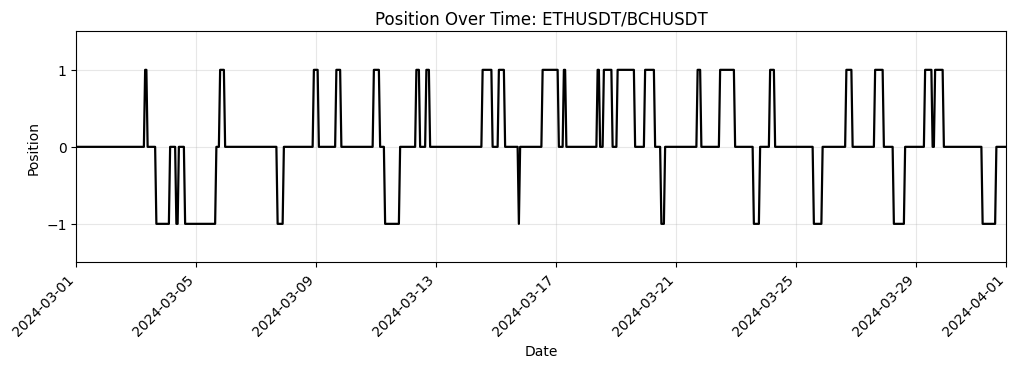

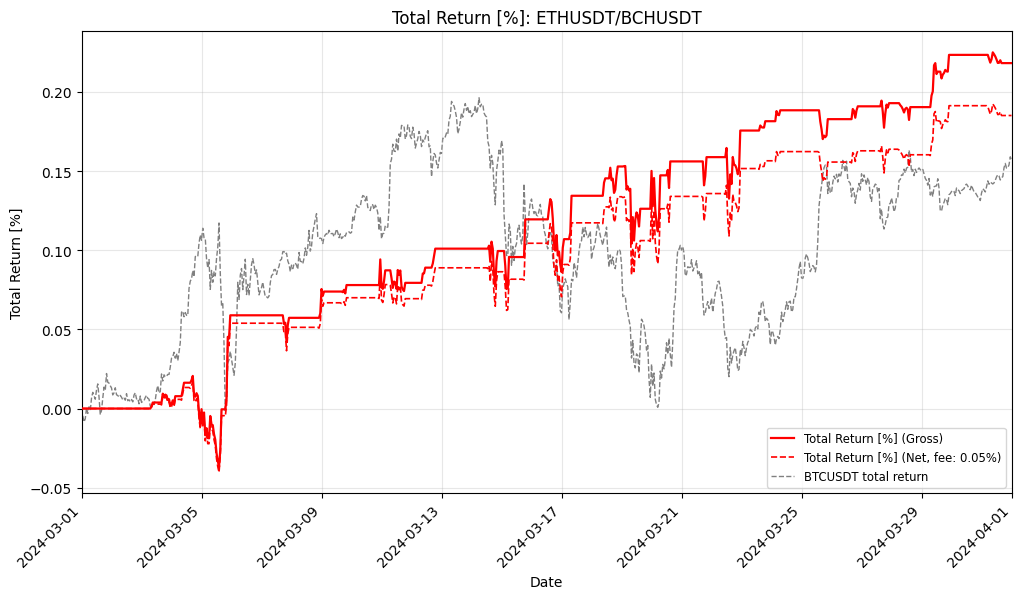

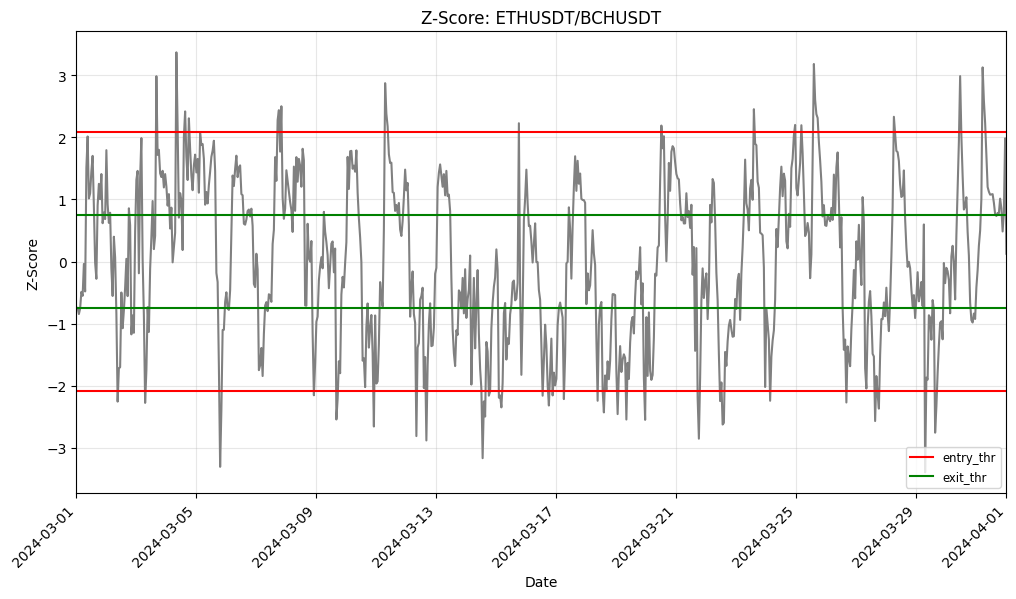

Pair: BTCUSDT/BCHUSDT
{'rolling_window': 11, 'entry_threshold': 2.257796174119653, 'exit_threshold': 0.9405693622232217, 'stop_loss': 2.569097267138565}
-0.3749
                      BTCUSDT  BCHUSDT  z_score    beta  entry_thr  exit_thr  \
open_time                                                                      
2024-03-01 00:00:00  61501.11    304.2  -0.2440  0.4474     2.2578    0.9406   
2024-03-01 01:00:00  61214.35    306.1  -0.5295  0.4157     2.2578    0.9406   
2024-03-01 02:00:00  60980.00    313.5  -0.9026  0.2922     2.2578    0.9406   
2024-03-01 03:00:00  61105.91    317.5  -0.4815  0.2807     2.2578    0.9406   
2024-03-01 04:00:00  61524.09    315.1   0.6725  0.1317     2.2578    0.9406   
...                       ...      ...      ...     ...        ...       ...   
2024-03-31 20:00:00  70840.00    680.5   1.1261  0.0047     2.2578    0.9406   
2024-03-31 21:00:00  70856.00    678.8   1.0120  0.0056     2.2578    0.9406   
2024-03-31 22:00:00  70970.00    680.8 

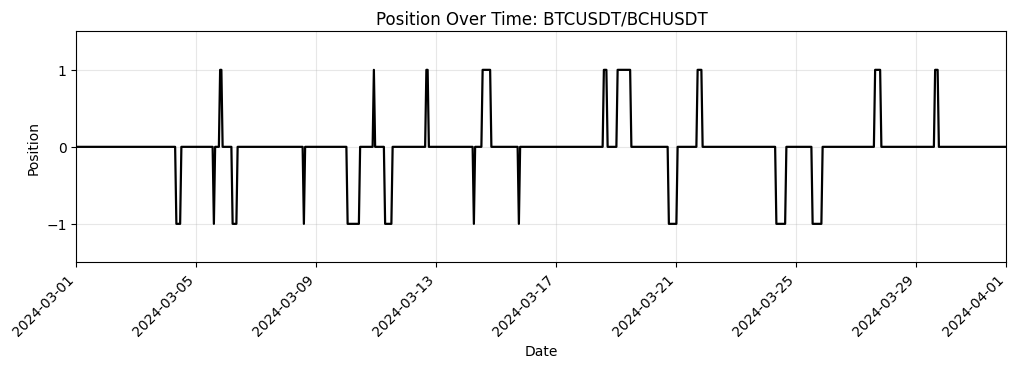

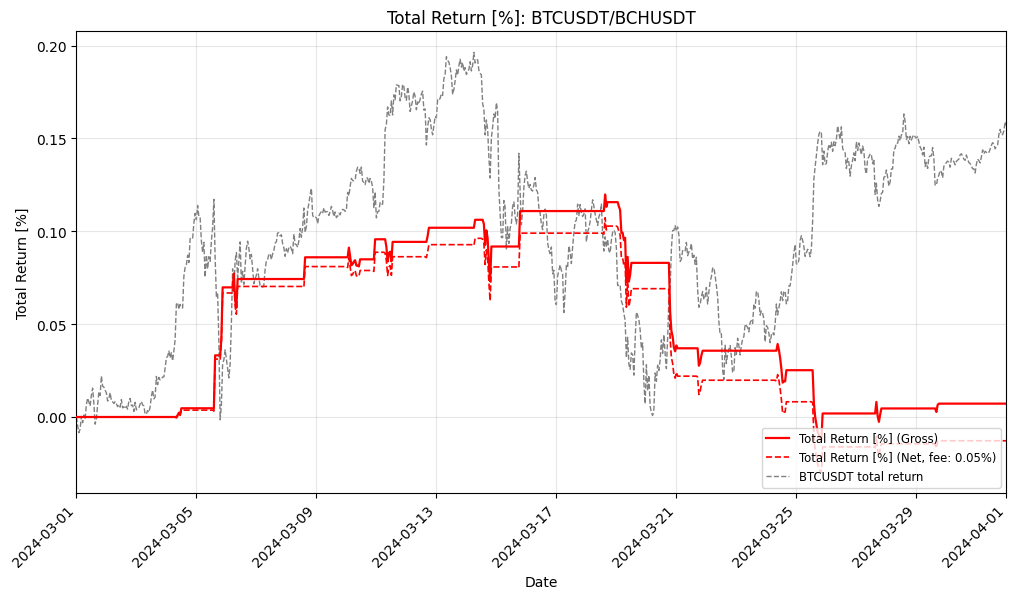

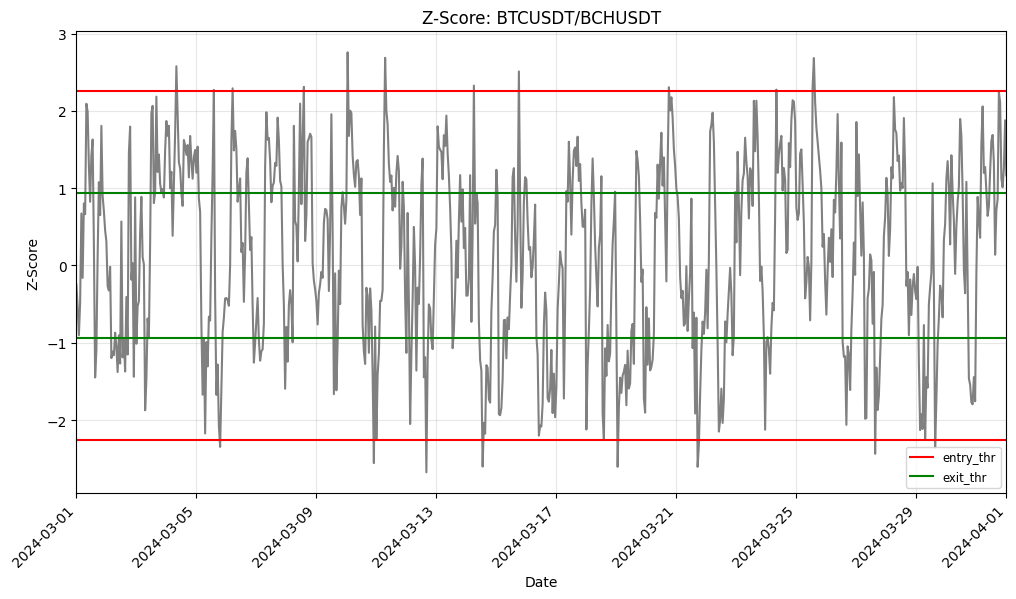

Pair: BNBUSDT/UNIUSDT
{'rolling_window': 15, 'entry_threshold': 2.233441489803809, 'exit_threshold': 0.8636419915014104, 'stop_loss': 2.2206389625027905}
11.9781
                     BNBUSDT  UNIUSDT  z_score    beta  entry_thr  exit_thr  \
open_time                                                                     
2024-03-01 00:00:00    404.3   11.212  -0.3484  0.2115     2.2334    0.8636   
2024-03-01 01:00:00    405.3   11.221   0.0058  0.2044     2.2334    0.8636   
2024-03-01 02:00:00    405.4   11.060   0.1363  0.1887     2.2334    0.8636   
2024-03-01 03:00:00    405.6   11.051   0.2195  0.1771     2.2334    0.8636   
2024-03-01 04:00:00    406.9   11.015   0.6703  0.1888     2.2334    0.8636   
...                      ...      ...      ...     ...        ...       ...   
2024-03-31 20:00:00    606.9   13.022   1.4897  0.0575     2.2334    0.8636   
2024-03-31 21:00:00    606.1   12.945   0.8743  0.2671     2.2334    0.8636   
2024-03-31 22:00:00    605.8   12.906   0.7606  

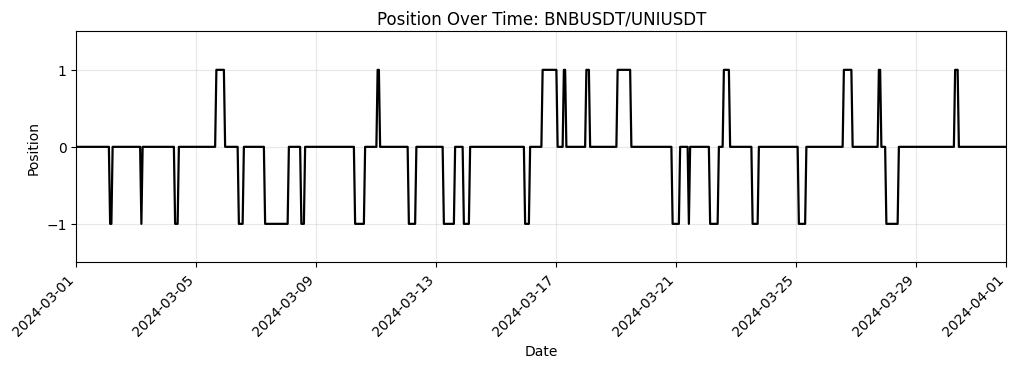

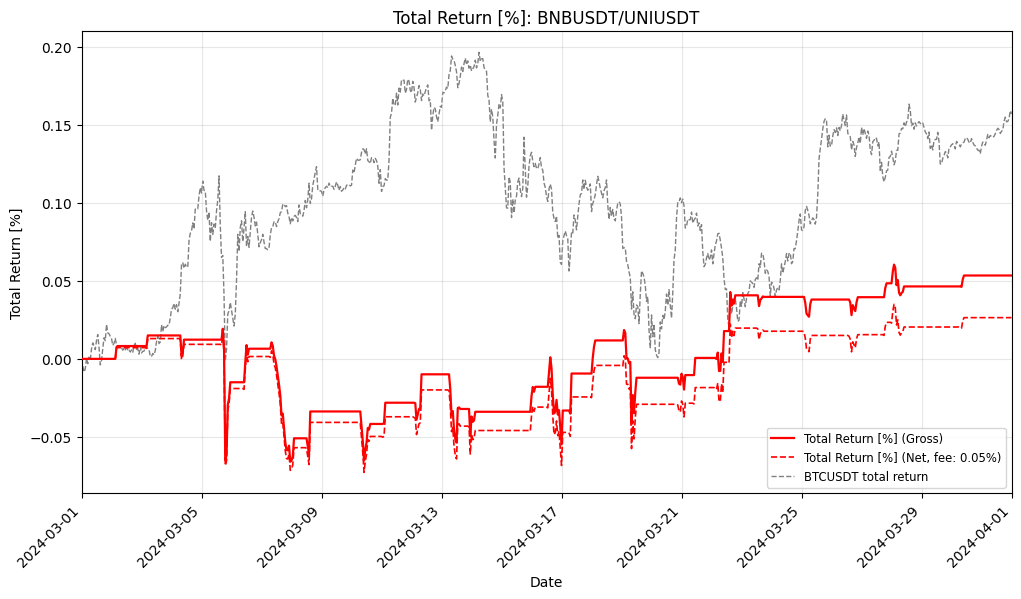

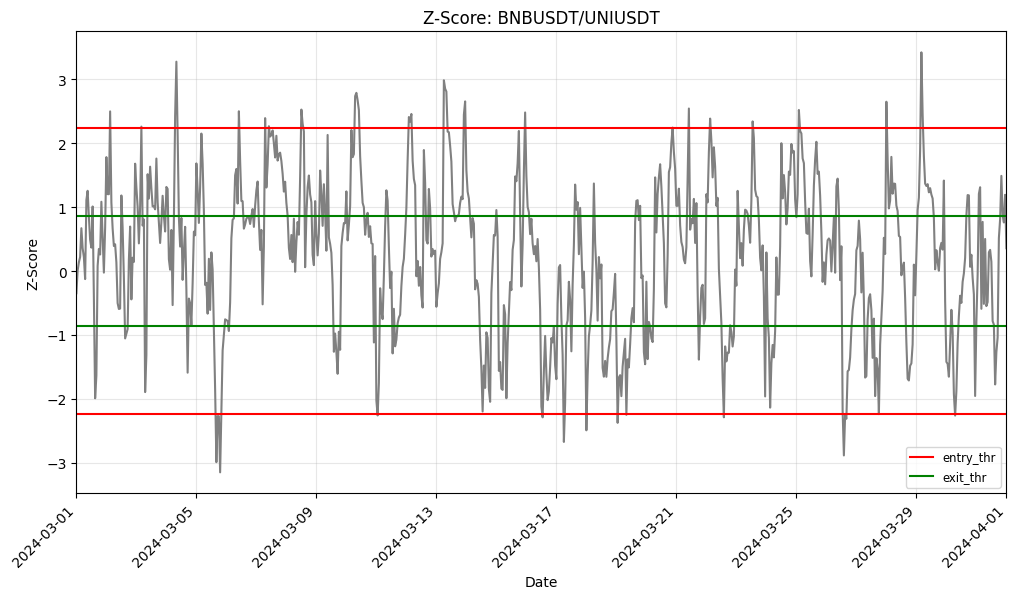

Pair: BTCUSDT/ADAUSDT
{'rolling_window': 14, 'entry_threshold': 2.032379143244705, 'exit_threshold': 0.9571060773364963, 'stop_loss': 2.182184958504074}
-0.8264
                      BTCUSDT  ADAUSDT  z_score    beta  entry_thr  exit_thr  \
open_time                                                                      
2024-03-01 00:00:00  61501.11   0.6718  -0.5320  0.3732     2.0324    0.9571   
2024-03-01 01:00:00  61214.35   0.6727  -0.7743  0.4218     2.0324    0.9571   
2024-03-01 02:00:00  60980.00   0.6763  -0.9428  0.4093     2.0324    0.9571   
2024-03-01 03:00:00  61105.91   0.6727  -0.6706  0.3962     2.0324    0.9571   
2024-03-01 04:00:00  61524.09   0.6743   0.1369  0.4100     2.0324    0.9571   
...                       ...      ...      ...     ...        ...       ...   
2024-03-31 20:00:00  70840.00   0.6490   1.3497  0.0193     2.0324    0.9571   
2024-03-31 21:00:00  70856.00   0.6461   1.2114  0.0630     2.0324    0.9571   
2024-03-31 22:00:00  70970.00   0.6488 

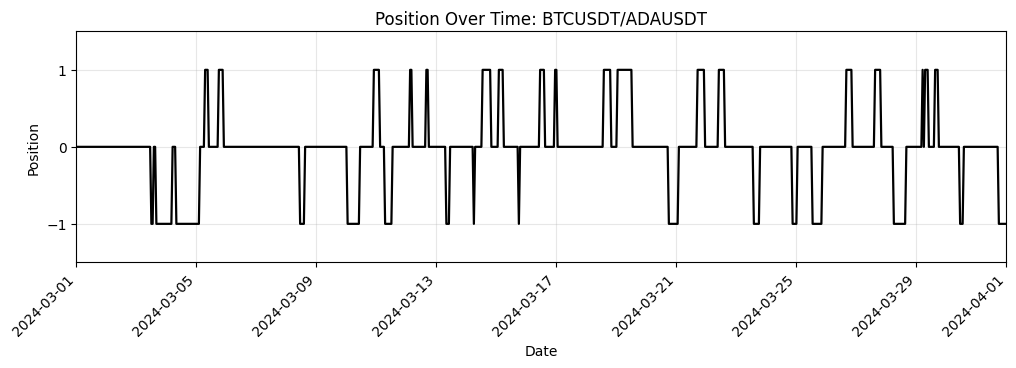

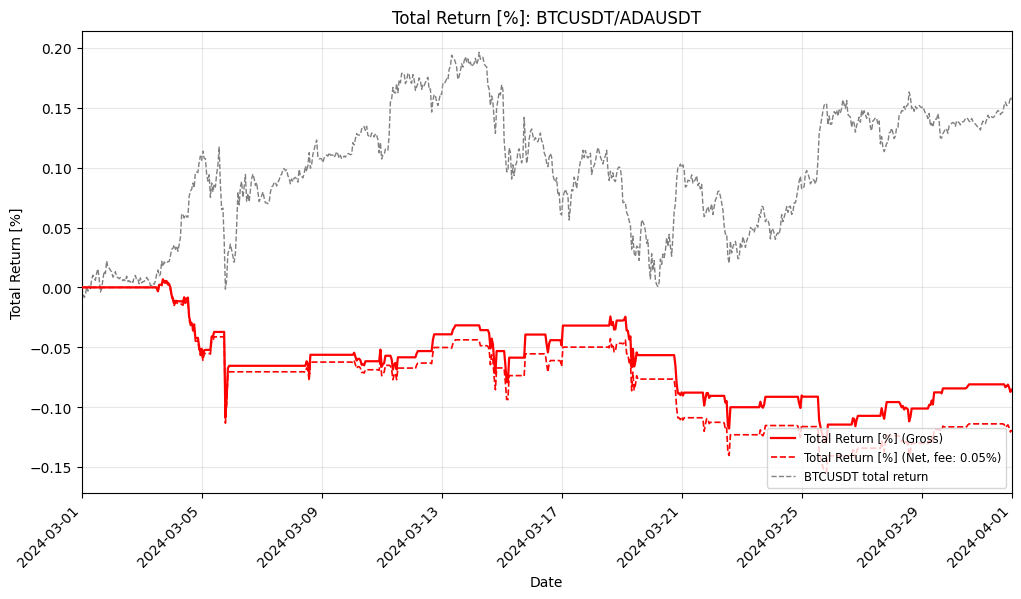

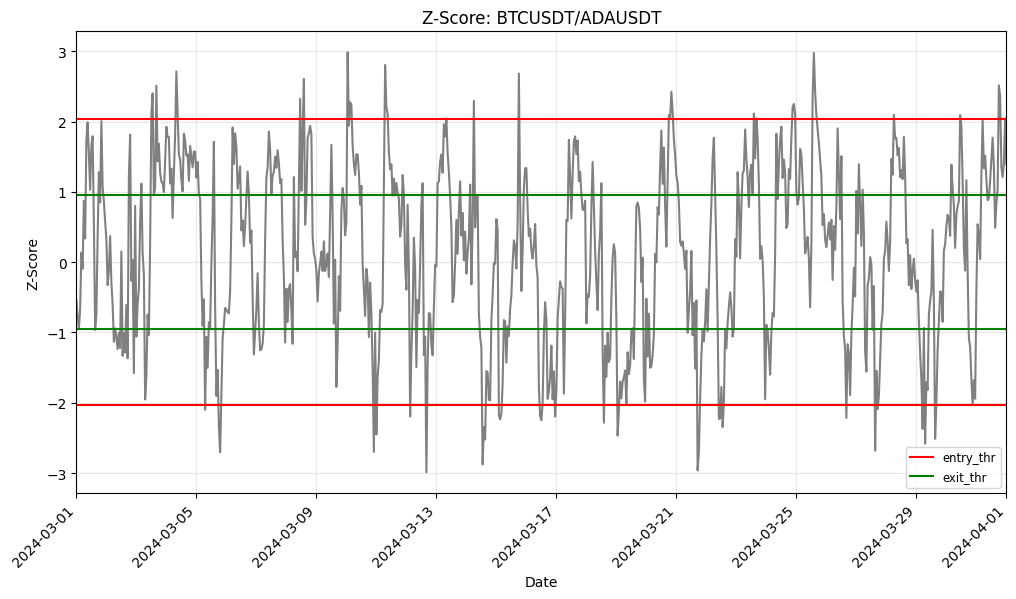

Pair: BTCUSDT/SOLUSDT
{'rolling_window': 10, 'entry_threshold': 2.3105691312197, 'exit_threshold': 0.8637789812116534, 'stop_loss': 2.1418483441932388}
-1.0933
                      BTCUSDT  SOLUSDT  z_score    beta  entry_thr  exit_thr  \
open_time                                                                      
2024-03-01 00:00:00  61501.11   132.93  -0.0813  0.2226     2.3106    0.8638   
2024-03-01 01:00:00  61214.35   135.71  -0.4275  0.2036     2.3106    0.8638   
2024-03-01 02:00:00  60980.00   133.85  -0.8736  0.1892     2.3106    0.8638   
2024-03-01 03:00:00  61105.91   133.94  -0.5524  0.1409     2.3106    0.8638   
2024-03-01 04:00:00  61524.09   137.49   0.5740  0.1477     2.3106    0.8638   
...                       ...      ...      ...     ...        ...       ...   
2024-03-31 20:00:00  70840.00   199.43   1.0488  0.4215     2.3106    0.8638   
2024-03-31 21:00:00  70856.00   199.70   0.9205  0.4509     2.3106    0.8638   
2024-03-31 22:00:00  70970.00   200.62  

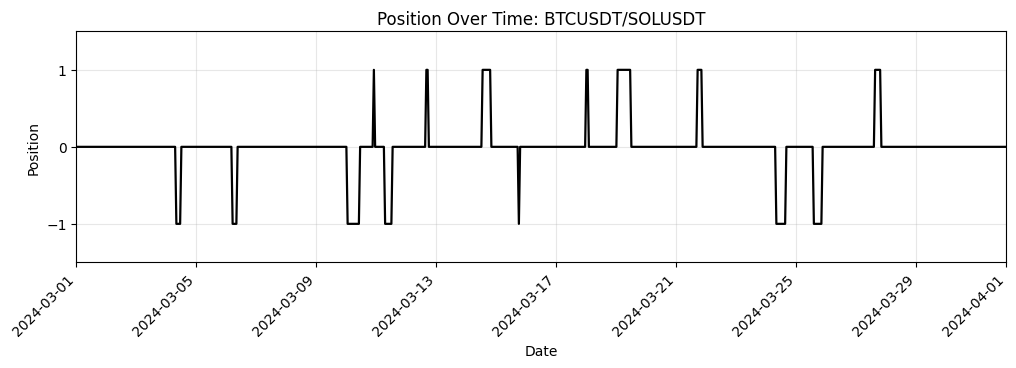

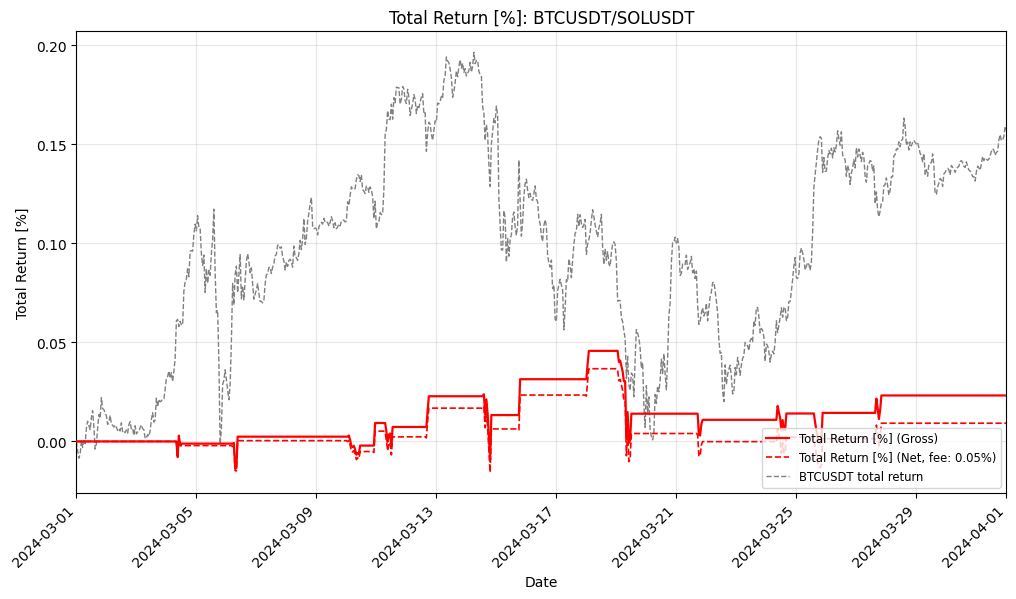

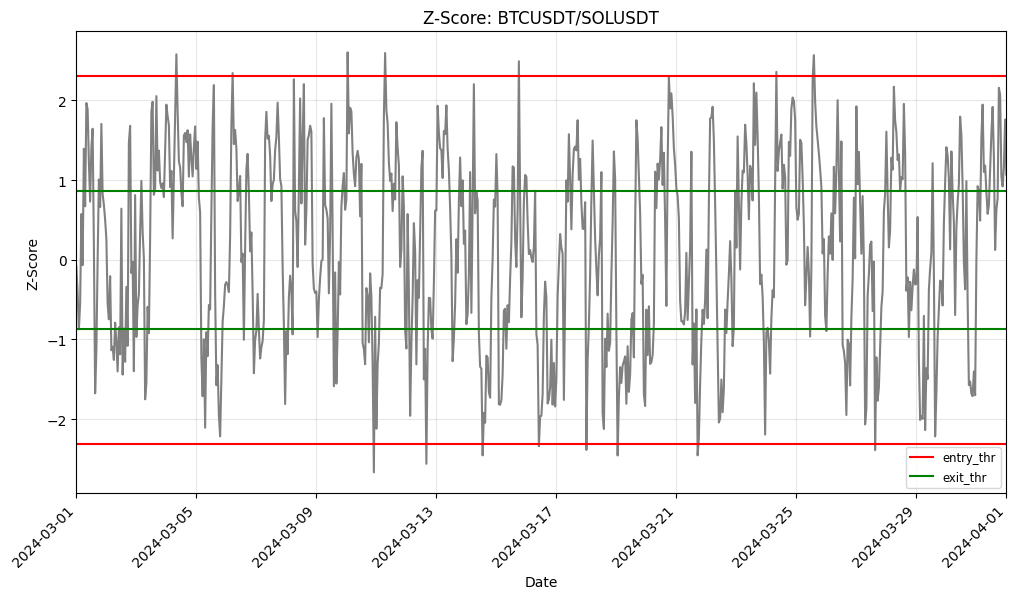

In [7]:
from modules.data_services.data_utils import add_returns
from modules.data_services.data_loaders import load_pair
from skopt.space import Integer, Real
from modules.core.models import Pair
from modules.performance.strategy import (
    calculate_stats,
    optimize_params,
    single_pair_strategy
)
from modules.visualization.plots import plot_positions, plot_zscore, plot_pnl

# Perform Bayesian Optimization
param_space = [
    Integer(10, 30, name="rolling_window"),
    Real(2.0, 2.5, name="entry_threshold"),
    Real(0.5, 1.0, name="exit_threshold"),
    Real(2.0, 3.0, name="stop_loss"),
]
metric = ("sortino_ratio_annual", "0.05% fee")

pairs = []
for ticker in tickers:
    ticker_x = ticker.split('-')[0]
    ticker_y = ticker.split('-')[1]
    print(f"Pair: {ticker_x}/{ticker_y}")

    best_params, best_score = optimize_params(ticker_x, ticker_y, fee_rate, initial_cash, position_size,
                                              pre_training_start, training_start, training_end,
                                              interval, beta_hedge, is_spread, param_space, metric)
    print(best_params)
    print(best_score)

    # === 2. Test ===

    # Load pair and calculate returns
    pair = load_pair(x=ticker_x, y=ticker_y, start=pre_test_start, end=test_end, interval=interval)
    add_returns(pair)

    entry_threshold = best_params["entry_threshold"]
    exit_threshold = best_params["exit_threshold"]
    stop_loss = best_params["stop_loss"]
    rolling_window = best_params["rolling_window"]

    # Run strategy
    pair.test_start = test_start
    pair.fee_rate = fee_rate
    pair.initial_cash = initial_cash

    single_pair_strategy(pair, rolling_window, entry_threshold, exit_threshold, stop_loss, position_size,
                         beta_hedge, is_spread)
    print(pair.data.drop(columns=['total_return', 'total_fees', 'net_return']))

    # Calculate statistics
    pair.stats = calculate_stats(pair, cfg.risk_free_rate_annual)
    print(pair.stats)

    pairs.append(pair)

    # Visualization
    plot_positions(pair, show=True, save=False)

    btc_data = load_data(
        tickers=['BTCUSDT'],
        start=test_start,
        end=test_end,
        interval=interval,
    )
    btc_data['BTC_return'] = btc_data['BTCUSDT'].pct_change()
    btc_data.loc[btc_data.index[0], 'BTC_return'] = 0.0
    btc_data['BTC_cum_return'] = (1 + btc_data['BTC_return']).cumprod() - 1

    plot_pnl(pair, btc_data, show=True, save=False)
    plot_zscore(pair, show=True, save=False)

In [8]:
cols_to_sum = ['position', 'total_return', 'total_fees', 'net_return']
summary_data = pairs[0].data[cols_to_sum].copy()
for p in pairs[1:]:
    summary_data += p.data[cols_to_sum]
summary = Pair(data=summary_data, start=pre_test_start, test_start=test_start, end=test_end,
               interval=interval, fee_rate=fee_rate, initial_cash=initial_cash * 5)
summary.data['total_return_pct'] = summary.data['total_return'] / (initial_cash * 5)
summary.data['net_return_pct'] = summary.data['net_return'] / (initial_cash * 5)
summary.data['position'] = summary.data['position'] / 5
summary.stats = calculate_stats(summary, cfg.risk_free_rate_annual)

In [9]:
# Show statistics
summary.stats

,0% fee,0.05% fee
metric,,
total_return,0.0433,0.0178
cagr,0.6467,0.2306
volatility,0.0030,0.0030
volatility_annual,0.2769,0.2782
max_drawdown,-0.0447,-0.0512
win_count,37.0000,35.0000
lose_count,20.0000,22.0000
win_rate,0.6491,0.6140
max_win,0.0160,0.0156


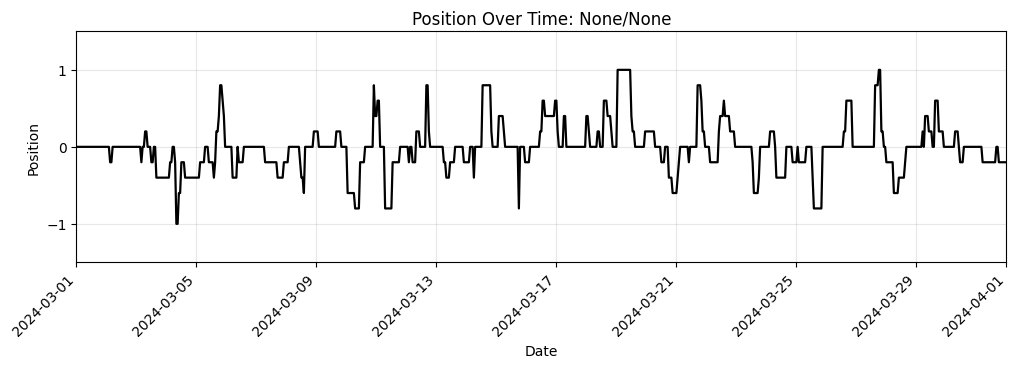

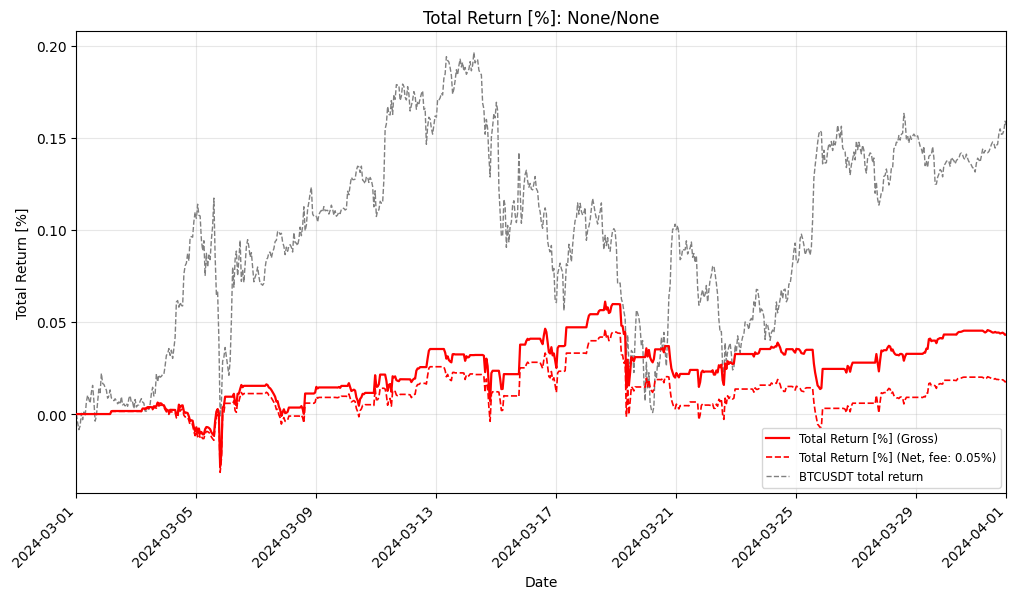

In [10]:
# Visualization
from modules.visualization.plots import plot_pnl

plot_positions(summary, show=True, save=False)

btc_data = load_data(
    tickers=['BTCUSDT'],
    start=test_start,
    end=test_end,
    interval=interval,
)
btc_data['BTC_return'] = btc_data['BTCUSDT'].pct_change()
btc_data.loc[btc_data.index[0], 'BTC_return'] = 0.0
btc_data['BTC_cum_return'] = (1 + btc_data['BTC_return']).cumprod() - 1

plot_pnl(summary, btc_data, show=True, save=False)

- druga para w większości benchmarków na okresie treningowym ma ujemne sortino ratio (źle dobrana, problem w selekcji par a nie parametrach)
- maksymalizowanie sortino ratio nie jest najefektywniejsze - wielokrotnie parametry o mniejszym sortino w okresie treningowym dawały regularny i wyższy pod względem total return wynik w okresie testowym